In [1]:
using DifferentialEquations

## Define the ThreeBody Problem
const threebody_μ = parse(Float64,"0.012277471"); const threebody_μ′ = 1 - threebody_μ

f = (t,u,du) -> begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+threebody_μ)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-threebody_μ′)^2 + u[2]^2)^(3/2)
  du[1] = u[3]
  du[2] = u[4]
  du[3] = u[1] + 2u[4] - threebody_μ′*(u[1]+threebody_μ)/D₁ - threebody_μ*(u[1]-threebody_μ′)/D₂
  du[4] = u[2] - 2u[3] - threebody_μ′*u[2]/D₁ - threebody_μ*u[2]/D₂
end

prob = ODEProblem(f,[0.994, 0.0, 0.0, parse(Float64,"-2.00158510637908252240537862224")])

t₀ = 0.0; T = parse(Float64,"17.0652165601579625588917206249")

tspan = [t₀,T]
tspan2 = [t₀,2T]
abstols = 1./10.^(3:13)
reltols = 1./10.^(0:10);

### 5th Order Runge-Kutta Methods

#### No full save


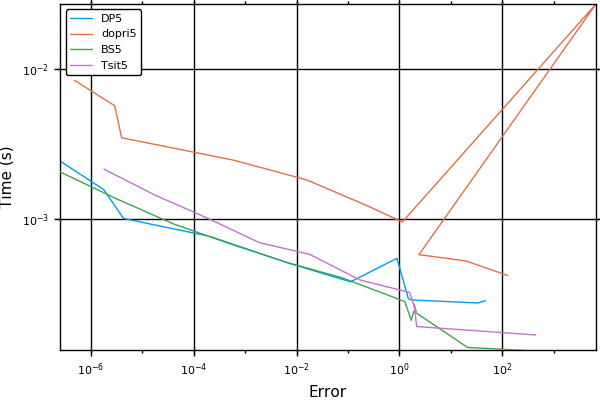

In [6]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          #Dict(:alg=>:ode45)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,save_timeseries=false,numruns=100)
plot(wp)

#### Full save, but no dense


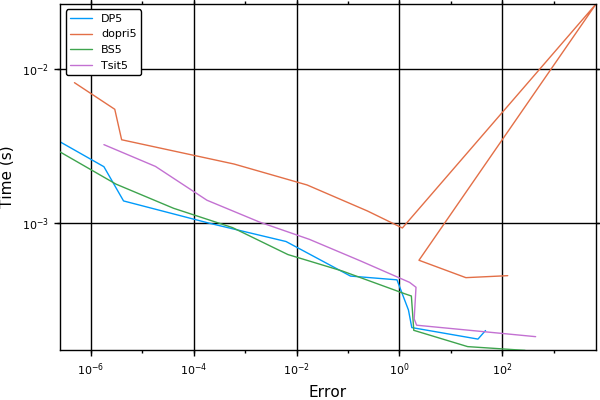

In [7]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          #Dict(:alg=>:ode45)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,numruns=100)
plot(wp)

#### Dense


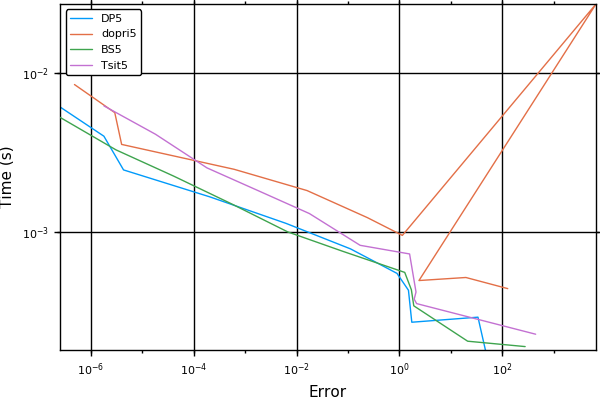

In [8]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:dopri5)
          #Dict(:alg=>:ode45)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,numruns=100)
plot(wp)

In these tests we see that most of the algorithms are close,with `BS5` and `DP5` showing much better than `Tsit5`. `ode45` errors.

### Higher Order Algorithms


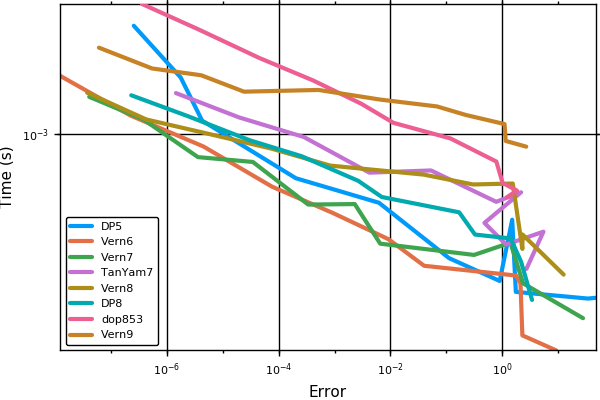

In [16]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern6)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern9)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)


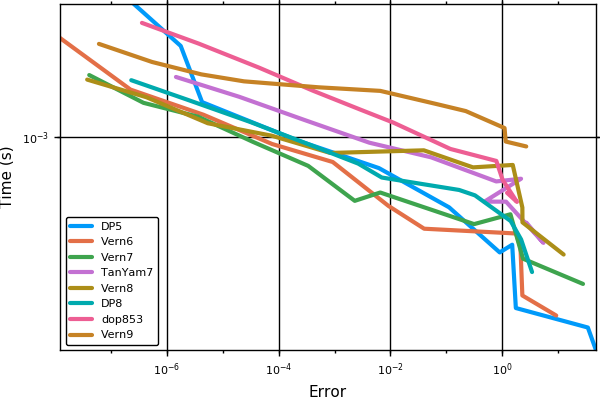

In [17]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern6)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern9)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,numruns=100)
plot(wp,lw=3)


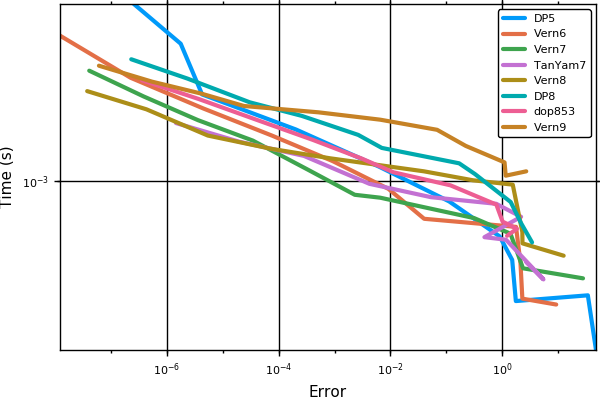

In [18]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern6)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern9)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,numruns=100)
plot(wp,lw=3)

In this test we see `:Vern6` and `:Vern7` shine.

### Other Algorithms

[DifferentialEquations.jl] Initializing backend: ODEInterface
[DifferentialEquations.jl] Initializing backend: Sundials


 in transpose(::String) at ./deprecated.jl:771
 in ctranspose at ./operators.jl:310 [inlined]
 in (::Base.##209#210)(::Tuple{Int64,String}) at ./<missing>:0
 in copy!(::Array{String,2}, ::Base.Generator{Base.Prod2{Base.OneTo{Int64},Array{String,1}},Base.##209#210}) at ./abstractarray.jl:477
 in _collect(::Type{String}, ::Base.Generator{Base.Prod2{Base.OneTo{Int64},Array{String,1}},Base.##209#210}, ::Base.HasShape) at ./array.jl:248
 in ctranspose(::Array{String,1}) at ./arraymath.jl:417
 in macro expansion at /home/crackauc/.julia/v0.5/DifferentialEquations/src/general/plotrecipes.jl:165 [inlined]
 in apply_recipe(::Dict{Symbol,Any}, ::DifferentialEquations.WorkPrecisionSet) at /home/crackauc/.julia/v0.5/RecipesBase/src/RecipesBase.jl:238
 in _process_userrecipes(::Plots.Plot{Plots.PyPlotBackend}, ::Dict{Symbol,Any}, ::Tuple{DifferentialEquations.WorkPrecisionSet}) at /home/crackauc/.julia/v0.5/Plots/src/pipeline.jl:73
 in _plot!(::Plots.Plot{Plots.PyPlotBackend}, ::Dict{Symbol,Any}, :


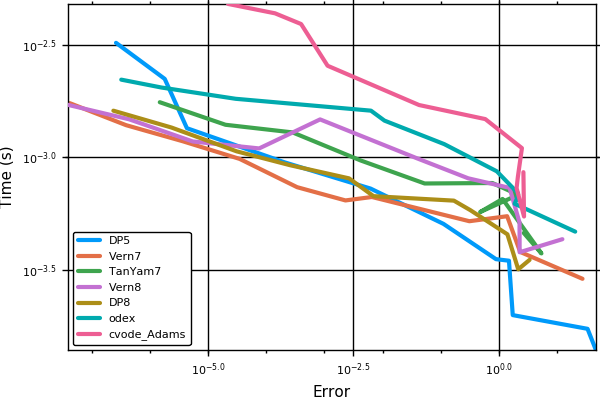

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [2]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:odex)
          Dict(:alg=>:cvode_Adams)
    ];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,numruns=100)
plot(wp,lw=3)

### Conclusion

As in the other tests, the DifferentialEquations.jl algorithms with the Verner Efficient methods are the most efficient solvers at stringent tolerances, while DP5 does well at crude tolerances.